<a href="https://colab.research.google.com/github/AndrewDiv/PMfMIVV/blob/main/DiplomaUpd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import numpy as np
import time
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

# Simulator

In [2]:
def Prevalence(host_num, single_strain_prob = 0.3):
  """ Simulate prevalence of strains in the host
    
  Parameters
  ----------
  host_num : int
    Number of patients
  single_strain_prob : float
    The probability that the host carries only one strain
       
  Returns
  -------
  prevs: ndarray, shape (host_num,)
    List of prevalence of one strain
  """
  prevs = np.zeros(host_num)
  for i in range(host_num):
    rnd = np.random.uniform()
    if rnd < single_strain_prob:
      prevs[i] = np.random.choice([0., 1.])
    else:
      prevs[i] = np.random.uniform()
  return prevs

In [3]:
def pi_i(r_s, prevs, er_rate):
  return prevs*(r_s[0]*(1 - er_rate) + (1 - r_s[0])*er_rate) + (1-prevs)*(r_s[1]*(1 - er_rate) + (1 - r_s[1])*er_rate)

def SimulateReads(haps, prevs, coverage = 100,  er_rate = 0.):
  """ Simulate reads from one host
    
  Parameters
  ----------
  haps : ndarray, shape (n, m)
    List of haplotypes
  prevs: ndarray, shape (k,)
    List of prevalences
  coverage: int
    Number of reads that cover sites
  er_rate: float
    Error rate 
       
  Returns
  -------
  data: ndarray, shape (host_num, hap_len, hap_num)
    Array of the number of observations of different alleles at each site
     for all patients
  """
  hap_len = len(haps[0])
  hap_num = len(haps)
  host_num = prevs.shape[0]
  data = np.empty((host_num, hap_len, hap_num))
  #print(hap_len, hap_num)
  for host in range(host_num):
    for snv in range(hap_len):
      als = np.zeros(hap_num)
      lcoverage = coverage
      als[1] = np.random.binomial(lcoverage, pi_i([haps[0][snv], haps[1][snv]], prevs[host], er_rate))
      als[0] = lcoverage - als[1]
      data[host][snv] = als
    
  return data

# Log-Likelihood

In [4]:
def LogFactorial(n):
  return sum(np.log(np.arange(1, n+1)))

def Coeff(reads):
  coeff = 0
  for _reads in reads:
    coeff += LogFactorial(_reads[0] + _reads[1]) - LogFactorial(_reads[1]) - LogFactorial(_reads[0])
  return coeff

In [5]:
def SingleHostLLH(prev, haps, samp_reads, er_rate=0.):
  """ Calculate minus log-likelihood of a single host
    
  Parameters
  ----------
  prev : float
    prevalence of 1st strain
  haps : ndarray, shape (hap_num, hap_len)
    List of haplotypes
  samp_reads: ndarray, shape (hap_len, hap_num)
    reads of host
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of a single host
  """
  llh = Coeff(samp_reads)
  for snv in range(len(samp_reads)):
    p = prev*(haps[0][snv]*(1.0 - er_rate) + (1.0 - haps[0][snv])*er_rate) + (1-prev)*(haps[1][snv]*(1.0 - er_rate) + (1.0 - haps[1][snv])*er_rate)
    #if p <= 0:
    #  print("snv probs in haps: ", [haps[i][snv] for i in range(hap_num)])
    #  print("error rate: ", er_rate) 
    #  print("prevs:", prev)
    
    llh += samp_reads[snv][1] * np.log(p) + samp_reads[snv][0] * np.log(1.0 - p)
  return -llh

def LLH(haps, prevs, samples, num_of_haplotypes, er_rate):
  """ Calculate minus log-likelihood of the hosts
    
  Parameters
  ----------
  haps : ndarray, shape (hap_num, m)
    List of haplotypes
  prevs: ndarray, shape (k,)
    List of prevalences of 1st strain
  samples: ndarray, shape (n, m, hap_num)
    reads of all hosts
  num_of_haplotypes: int
    hap_num
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of the whole sample
  """  
  haps = np.reshape(haps, (num_of_haplotypes, -1))
  #print(haps)
  llh = 0
  for sample_num in range(len(samples)):
      llh += SingleHostLLH(prevs[sample_num], haps, samples[sample_num], er_rate)
  #print('LLH:', llh)
  return llh

# Optimisation

In [6]:
def optimise_prevs_const_haps(haps, prevs, samp_reads, hap_num=2, er_rate=0.):
  haps = np.reshape(haps, (hap_num, -1))
  #prevs = np.reshape(prevs, (len(samp_reads), -1))
  #print(prevs.shape)
  llh = 0.
  opt_prevs = np.empty(len(prevs))
  bnds = optimize.Bounds(0., 1.)
  #bnds = ((0, 1),)
  for host_num in range(len(samp_reads)):
    opt_res = optimize.minimize(SingleHostLLH, prevs[host_num], args=(haps, samp_reads[host_num], er_rate),
                                method='trust-constr', bounds=bnds, options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
    opt_prevs[host_num] = opt_res.x
    llh += opt_res.fun
    
  return opt_prevs

In [7]:
def optimise_haps_const_prevs(haps, prevs, samp_reads, num_of_hapl=2, er_rate=0.):
  #print(haps)
  #prevs = np.reshape(prevs, (len(samp_reads), -1))
  bnds = optimize.Bounds([0. for _ in range(len(haps))], [1. for _ in range(len(haps))])
  #bnds = ((0., 1.), ) * len(haps)
  opt_res = optimize.minimize(LLH, haps, args=(prevs, samp_reads, num_of_hapl, er_rate),
                                method='trust-constr', bounds=bnds, 
                                options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
  opt_haps = opt_res.x

  return opt_haps

# Testing

In [ ]:
exmp_haplotypes = [[1., 1., 0., 0.],
              [0., 0., 1., 1.]] # Probabilistic description of haplotypes

hap_len = len(exmp_haplotypes[0]) # Number of sites
coverage = 100 # coverage sites
hap_num = 2  # Number of haplotypes(strains)
samp_num = 10  # Number of samples(patients)
er_rate = 0.0  # Error rate
iter_num = 50

np.random.seed(2022)

In [ ]:

exmp_prevs = Prevalence(samp_num, 0.3)
#print(exmp_prevs)

patients_data = SimulateReads(exmp_haplotypes, exmp_prevs, er_rate= er_rate)
#print(patients_data)



In [ ]:
start_time = time.time()

haps_init = np.random.uniform(size = hap_num * hap_len)
prev_init = np.random.uniform(size = samp_num)


opt_haps = optimise_haps_const_prevs(haps_init, prev_init, patients_data, er_rate= er_rate)
opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, patients_data, er_rate= er_rate)

for _ in range(6):
    opt_haps = optimise_haps_const_prevs(opt_haps, opt_prevs, patients_data, er_rate= er_rate)
    opt_prevs = optimise_prevs_const_haps(opt_haps, opt_prevs, patients_data, er_rate= er_rate)

print("time elapsed: {:.2f}s".format(time.time() - start_time))

print('RESULT')
print("opt_haps:", np.reshape(opt_haps, (hap_num, -1)))
print("real_haps:", exmp_haplotypes)
print("opt_prevs:", opt_prevs)
print("real_prevs:", exmp_prevs)

In [ ]:
e_time_err = []
p_acc_err = []
h_acc_err = []

for i in [0., 0.001, 0.01, 0.05]:
  e = 0.
  p = 0.
  h = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(samp_num, 0.3)

    patients_data = SimulateReads(exmp_haplotypes, exmp_prevs, er_rate=i)

    start_time = time.time()

    haps_init = np.random.uniform(size = hap_num * hap_len)
    prev_init = np.random.uniform(size = samp_num)


    opt_haps = optimise_haps_const_prevs(haps_init, prev_init, patients_data, er_rate= i)
    opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, patients_data, er_rate= i)

    for _ in range(6):
      opt_haps = optimise_haps_const_prevs(opt_haps, opt_prevs, patients_data, er_rate= i)
      opt_prevs = optimise_prevs_const_haps(opt_haps, opt_prevs, patients_data, er_rate= i)

    et = time.time() - start_time
    print("time elapsed: {:.2f}s".format(et))

    print('RESULT')
    print("opt_haps:", np.reshape(opt_haps, (hap_num, -1)))
    print("real_haps:", exmp_haplotypes)
    print("opt_prevs:", opt_prevs)
    print("real_prevs:", exmp_prevs)

    if np.linalg.norm(opt_prevs - exmp_prevs) < np.linalg.norm(opt_prevs - (1. - exmp_prevs)):
      prev_acc = np.linalg.norm(opt_prevs - exmp_prevs) / np.linalg.norm(exmp_prevs)
      o_haps = np.reshape(opt_haps, (hap_num, -1))
      haps_acc = np.array([np.linalg.norm(o_haps[0] - exmp_haplotypes[0])/np.linalg.norm(exmp_haplotypes[0]), np.linalg.norm(o_haps[1] - exmp_haplotypes[1])/np.linalg.norm(exmp_haplotypes[1])])
    else:
      prev_acc = np.linalg.norm(opt_prevs - (1. - exmp_prevs)) / np.linalg.norm(1. - exmp_prevs)
      o_haps = np.reshape(opt_haps, (hap_num, -1))
      haps_acc = np.array([np.linalg.norm(o_haps[0] - exmp_haplotypes[1])/np.linalg.norm(exmp_haplotypes[1]), np.linalg.norm(o_haps[1] - exmp_haplotypes[0])/np.linalg.norm(exmp_haplotypes[0])])

    print("Evaluation error of prevalences:", prev_acc)
    print("Evaluation error of haplotypes:", haps_acc)
    p += prev_acc
    h += haps_acc
    e += et

  e_time_err.append(e/iter_num)
  p_acc_err.append(p/iter_num)
  h_acc_err.append(h/iter_num)

print(e_time_err)
print(p_acc_err)
print(h_acc_err)

In [15]:
e_time_err = [11.606363053321838, 11.495853495597839, 11.429220314025878, 11.463208422660827]
prev_er_err = [0.15025852528099926, 0.13783943387537245, 0.1334673956274906, 0.1065205419052178]
haps_er_err = np.array([[0.14354043, 0.1549614 ], [0.12143525, 0.15986291], [0.12704457, 0.12002845], [0.07891973, 0.10172802]])

#Simultaneous optimisation

In [9]:
def SmlLLH(prev_haps, samp_reads, er_rate=0.):
  """ Calculate minus log-likelihood of a sample
    
  Parameters
  ----------
  prev_haps : ndarray, shape (n + hap_len*hap_num,)
    prevalence and haplotypes of sample
  samp_reads: ndarray, shape (n, hap_len, hap_num)
    reads of hosts
  er_rate: float
    Error rate 
       
  Returns
  -------
  -llh: float
    log-likelihood of sample
  """
  pn = samp_reads.shape[0]
  hl = samp_reads.shape[1]
  llh = 0.
  for sample_num in range(pn):
    llh += Coeff(samp_reads[sample_num])
    #print(Coeff(samp_reads[sample_num]))
    #print("llh:", llh)
    #print("llh:",len(llh))
    for snv in range(hl):
      p = prev_haps[sample_num]*(prev_haps[pn+snv]*(1.0 - er_rate) + (1.0 - prev_haps[pn+snv])*er_rate) + (1-prev_haps[sample_num])*(prev_haps[pn+hl+snv]*(1.0 - er_rate) + (1.0 - prev_haps[pn+hl+snv])*er_rate)
      #if p <= 0:
      #  print("snv probs in haps: ", [prev_haps[pn+snv], prev_haps[pn+hl+snv]])
      #  print("error rate: ", er_rate) 
      #  print("prevs:", prev_haps[sample_num])
      llh += samp_reads[sample_num][snv][1] * np.log(p) + samp_reads[sample_num][snv][0] * np.log(1.0 - p)
  return -llh

In [10]:
def optimise_haps_and_prevs(prev_haps, samp_reads, er_rate=0.):
  bnds = optimize.Bounds([0. for _ in range(len(prev_haps))], [1. for _ in range(len(prev_haps))])
  #bnds = ((0., 1.), ) * len(prev_haps)
  #print(samp_reads.shape)
  opt_res = optimize.minimize(SmlLLH, prev_haps, args=(samp_reads, er_rate),
                                method='trust-constr', bounds=bnds, 
                                options = {'xtol': 1e-6, 'gtol': 1e-6, 'barrier_tol': 1e-6, 'maxiter': 100})
  opt_haps = opt_res.x

  return opt_haps

#Simultaneous optimisation Testing

In [ ]:
start_time = time.time()

prev_haps_init = np.random.uniform(size = samp_num + hap_num*hap_len)

opt_prev_haps = optimise_haps_and_prevs(prev_haps_init, patients_data, er_rate)


for _ in range(6):
    opt_prev_haps = optimise_haps_and_prevs(opt_prev_haps, patients_data, er_rate)

print("time elapsed: {:.2f}s".format(time.time() - start_time))

print('RESULT')
print("opt_prevs:", opt_prev_haps[:samp_num])
print("real_prevs:", exmp_prevs)
print("opt_haps:", np.reshape(opt_prev_haps[samp_num:], (hap_num, -1)))
print("real_haps:", exmp_haplotypes)


In [ ]:
e_time_err_sim = []
p_acc_err_sim = []
h_acc_err_sim = []

for i in [0., 0.001, 0.01, 0.05]:
  e = 0.
  p = 0.
  h = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(samp_num, 0.3)

    patients_data = SimulateReads(exmp_haplotypes, exmp_prevs, er_rate=i)

    start_time = time.time()

    prev_haps_init = np.random.uniform(size = samp_num + hap_num*hap_len)

    opt_prev_haps = optimise_haps_and_prevs(prev_haps_init, patients_data, i)


    for _ in range(6):
        opt_prev_haps = optimise_haps_and_prevs(opt_prev_haps, patients_data, i)

    et = time.time() - start_time
    print("time elapsed: {:.2f}s".format(et))

    print('RESULT')
    print("opt_prevs:", opt_prev_haps[:samp_num])
    print("real_prevs:", exmp_prevs)
    print("opt_haps:", np.reshape(opt_prev_haps[samp_num:], (hap_num, -1)))
    print("real_haps:", exmp_haplotypes)

    if np.linalg.norm(opt_prev_haps[:samp_num] - exmp_prevs) < np.linalg.norm(opt_prev_haps[:samp_num] - (1. - exmp_prevs)):
      prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - exmp_prevs) / np.linalg.norm(exmp_prevs)
      o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
      haps_acc = np.array([np.linalg.norm(o_haps[0] - exmp_haplotypes[0])/np.linalg.norm(exmp_haplotypes[0]), np.linalg.norm(o_haps[1] - exmp_haplotypes[1])/np.linalg.norm(exmp_haplotypes[1])])
    else:
      prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - (1. - exmp_prevs)) / np.linalg.norm(1. - exmp_prevs)
      o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
      haps_acc = np.array([np.linalg.norm(o_haps[0] - exmp_haplotypes[1])/np.linalg.norm(exmp_haplotypes[1]), np.linalg.norm(o_haps[1] - exmp_haplotypes[0])/np.linalg.norm(exmp_haplotypes[0])])

    print("Evaluation error of prevalences:", prev_acc)
    print("Evaluation error of haplotypes:", haps_acc)
    p += prev_acc
    h += haps_acc
    e += et

  e_time_err_sim.append(e/iter_num)
  p_acc_err_sim.append(p/iter_num)
  h_acc_err_sim.append(h/iter_num)

print(e_time_err_sim)
print(p_acc_err_sim)
print(h_acc_err_sim)

In [16]:
e_time_err_sim = [14.418187551498413, 15.028812022209168, 15.970481452941895, 15.317630052566528]
prev_er_err_sim = [0.07057834009811591, 0.054853598500949466, 0.04241109048366067, 0.0573622407564026]
haps_er_err_sim = np.array([[0.01988807, 0.08586124], [0.03693206, 0.03040255], [0.0233661 , 0.02881518], [0.03440041, 0.03780317]])

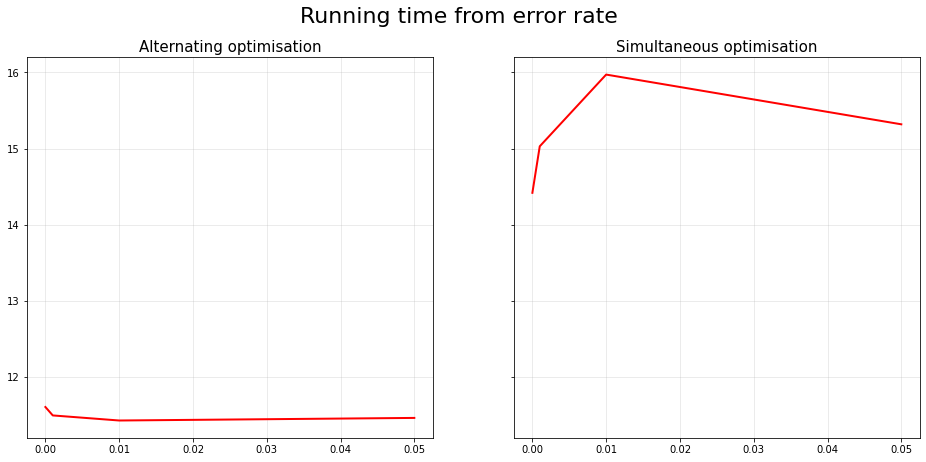

In [17]:
fig_er_1, ax_er_1 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_er_1.suptitle('Running time from error rate', fontsize=22)
ax_er_1[0].plot([0., 0.001, 0.01, 0.05], e_time_err, 'r', linewidth=2)
ax_er_1[0].set_title('Alternating optimisation', fontsize=15)
ax_er_1[0].grid(axis='both', alpha=.3)

ax_er_1[1].plot([0., 0.001, 0.01, 0.05], e_time_err_sim, 'r', linewidth=2)
ax_er_1[1].set_title('Simultaneous optimisation', fontsize=15)
ax_er_1[1].grid(axis='both', alpha=.3)

plt.show()

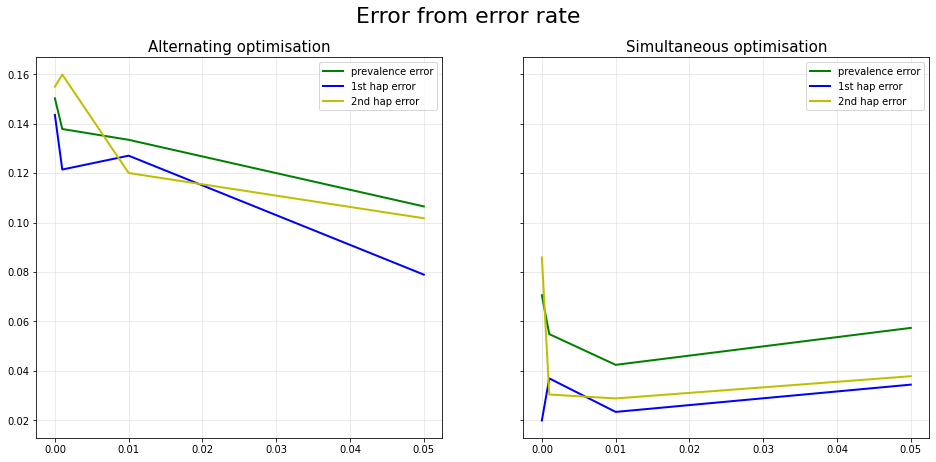

In [18]:
fig_er_2, ax_er_2 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_er_2.suptitle('Error from error rate', fontsize=22)
ax_er_2[0].plot([0., 0.001, 0.01, 0.05], prev_er_err, 'g', linewidth=2, label='prevalence error')
ax_er_2[0].plot([0., 0.001, 0.01, 0.05], haps_er_err[:, 0], 'b', linewidth=2, label='1st hap error')
ax_er_2[0].plot([0., 0.001, 0.01, 0.05], haps_er_err[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_er_2[0].set_title('Alternating optimisation', fontsize=15)
ax_er_2[0].grid(axis='both', alpha=.3)
ax_er_2[0].legend()

ax_er_2[1].plot([0., 0.001, 0.01, 0.05], prev_er_err_sim, 'g', linewidth=2, label='prevalence error')
ax_er_2[1].plot([0., 0.001, 0.01, 0.05], haps_er_err_sim[:, 0], 'b', linewidth=2, label='1st hap error')
ax_er_2[1].plot([0., 0.001, 0.01, 0.05], haps_er_err_sim[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_er_2[1].set_title('Simultaneous optimisation', fontsize=15)
ax_er_2[1].grid(axis='both', alpha=.3)
ax_er_2[1].legend()

plt.show()

# Test of methods on different data

In [12]:
def alter_opt(real_haplotypes, real_prevs, host_data):
  start_time = time.time()

  haps_init = np.random.uniform(size = hap_num * hap_len)
  prev_init = np.random.uniform(size = len(host_data))


  opt_haps = optimise_haps_const_prevs(haps_init, prev_init, host_data)
  opt_prevs = optimise_prevs_const_haps(opt_haps, prev_init, host_data)

  for _ in range(6):
      opt_haps = optimise_haps_const_prevs(opt_haps, opt_prevs, host_data)
      opt_prevs = optimise_prevs_const_haps(opt_haps, opt_prevs, host_data)
  
  exec_time = time.time() - start_time

  print("time elapsed: {:.2f}s".format(exec_time))

  print('RESULT')
  print("opt_haps:", np.reshape(opt_haps, (hap_num, -1)))
  print("real_haps:", real_haplotypes)
  print("opt_prevs:", opt_prevs)
  print("real_prevs:", real_prevs)

  if np.linalg.norm(opt_prevs - real_prevs) < np.linalg.norm(opt_prevs - (1. - real_prevs)):
    prev_acc = np.linalg.norm(opt_prevs - real_prevs) / np.linalg.norm(real_prevs)
    o_haps = np.reshape(opt_haps, (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0]), np.linalg.norm(o_haps[1] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1])])
  else:
    prev_acc = np.linalg.norm(opt_prevs - (1. - real_prevs)) / np.linalg.norm(1. - real_prevs)
    o_haps = np.reshape(opt_haps, (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1]), np.linalg.norm(o_haps[1] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0])])

  print("Evaluation error of prevalences:", prev_acc)
  print("Evaluation error of haplotypes:", haps_acc)
  
  return exec_time, prev_acc, haps_acc

In [13]:
def sim_opt(real_haplotypes, real_prevs, host_data, hl):
  samp_num = len(host_data)
  start_time = time.time()

  prev_haps_init = np.random.uniform(size = samp_num + hap_num*hl)

  opt_prev_haps = optimise_haps_and_prevs(prev_haps_init, host_data)


  for _ in range(6):
    opt_prev_haps = optimise_haps_and_prevs(opt_prev_haps, host_data)

  exec_time = time.time() - start_time
  print("time elapsed: {:.2f}s".format(exec_time))

  print('RESULT')
  print("opt_prevs:", opt_prev_haps[:samp_num])
  print("real_prevs:", real_prevs)
  print("opt_haps:", np.reshape(opt_prev_haps[samp_num:], (hap_num, -1)))
  print("real_haps:", real_haplotypes)

  if np.linalg.norm(opt_prev_haps[:samp_num] - real_prevs) < np.linalg.norm(opt_prev_haps[:samp_num] - (1. - real_prevs)):
    prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - real_prevs) / np.linalg.norm(real_prevs)
    o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0]), np.linalg.norm(o_haps[1] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1])])
  else:
    prev_acc = np.linalg.norm(opt_prev_haps[:samp_num] - (1. - real_prevs)) / np.linalg.norm(1. - real_prevs)
    o_haps = np.reshape(opt_prev_haps[samp_num:], (hap_num, -1))
    haps_acc = np.array([np.linalg.norm(o_haps[0] - real_haplotypes[1])/np.linalg.norm(real_haplotypes[1]), np.linalg.norm(o_haps[1] - real_haplotypes[0])/np.linalg.norm(real_haplotypes[0])])

  print("Evaluation error of prevalences:", prev_acc)
  print("Evaluation error of haplotypes:", haps_acc)
  
  return exec_time, prev_acc, haps_acc

## Various number of sites

In [ ]:
e_time = []
p_acc = []
h_acс = []
for sites in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
  haps = np.ones((2, sites))
  haps[0][int(sites/2):]=0.
  haps[1][:int(sites/2)]=0.
  hap_len = len(haps[0])
  exec_time_alt = 0.
  prev_ac_alt = 0.
  haps_ac_alt = np.zeros(2)
  for j in range(10):
    exmp_prevs = Prevalence(samp_num, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = alter_opt(haps, exmp_prevs, patients_data)

    exec_time_alt+= exec_time
    prev_ac_alt += prev_ac
    haps_ac_alt += haps_ac
    
  
  p_acc.append(prev_ac_alt/10)
  h_acс.append(haps_ac_alt/10)
  e_time.append(exec_time_alt/10)
  
print("Runtime:", e_time)
print("Eval prev error:", p_acc)
print("Eval haps error:", h_acс)

In [24]:
et_alt = [8.422649216651916, 10.974277091026305, 20.781901383399962, 28.98297288417816, 41.10644128322601, 54.13058240413666, 65.40226240158081, 80.91165091991425, 99.41794052124024, 115.01640429496766]
prev_er_alt = [0.05756270684913186, 0.031176166479283368, 0.06086153197798601, 0.166290544294517, 0.0802155427821928, 0.10488824254310439, 0.08740351745273736, 0.055516342163779375, 0.14458084895814177, 0.13850935453806407]
haps_er_alt = np.array([[0.20550092, 0.12288938], [0.16380964, 0.20472457], [0.14825041, 0.1414706 ], [0.19769273, 0.21627161], [0.19920709, 0.04842689], [0.12386801, 0.26379786], [0.16345951, 0.22724878], [0.07711663, 0.25540098], [0.06350164, 0.20933651], [0.20013397, 0.11811433]])

In [ ]:
e_time_sim = []
p_acc_sim = []
h_acс_sim = []
for sites in [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]:
  haps = np.ones((2, sites))
  haps[0][int(sites/2):]=0.
  haps[1][:int(sites/2)]=0.
  hap_len = len(haps[0])
  exec_time_sim = 0.
  prev_ac_sim = 0.
  haps_ac_sim = np.zeros(2)
  for j in range(10):
    exmp_prevs = Prevalence(samp_num, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = sim_opt(haps, exmp_prevs, patients_data, hap_len)
    exec_time_sim += exec_time
    prev_ac_sim += prev_ac
    haps_ac_sim += haps_ac
  
  p_acc_sim.append(prev_ac_sim/10)
  h_acс_sim.append(haps_ac_sim/10)
  e_time_sim.append(exec_time_sim/10)
  
print("Runtime:", e_time_sim)
print("Eval prev error:", p_acc_sim)
print("Eval haps error:", h_acс_sim)

In [23]:
et_sim = [9.743120765686035, 13.864215731620789, 18.893071866035463, 24.898119068145753, 28.310753798484804, 35.15338168144226, 43.542009806633, 55.336060762405396, 56.716138410568234, 63.70626871585846]
prev_er_sim = [0.05756270684913186, 0.031176166479283368, 0.06086153197798601, 0.166290544294517, 0.0802155427821928, 0.10488824254310439, 0.08740351745273736, 0.055516342163779375, 0.14458084895814177, 0.13850935453806407]
haps_er_sim = np.array([[0.03202679, 0.0013607 ], [0.00621114, 0.00529575], [0.01554036, 0.03891018], [0.17756932, 0.06627235], [0.03672652, 0.05007581], [0.12741297, 0.08243161], [0.06421603, 0.04078828], [0.0492978, 0.0373994], [0.17101506, 0.04616656], [0.08419729, 0.19306295]])

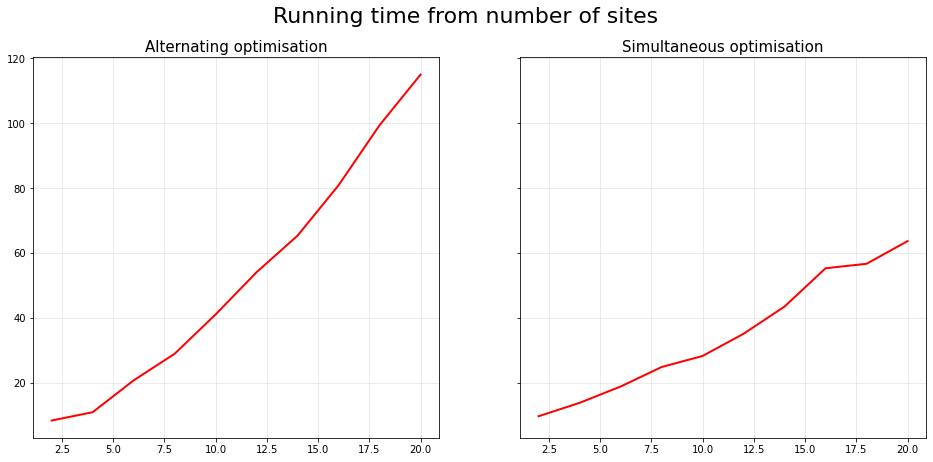

In [21]:
fig_sn_1, ax_sn_1 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_sn_1.suptitle('Running time from number of sites', fontsize=22)
ax_sn_1[0].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], et_alt, 'r', linewidth=2)
ax_sn_1[0].set_title('Alternating optimisation', fontsize=15)
ax_sn_1[0].grid(axis='both', alpha=.3)

ax_sn_1[1].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], et_sim, 'r', linewidth=2)
ax_sn_1[1].set_title('Simultaneous optimisation', fontsize=15)
ax_sn_1[1].grid(axis='both', alpha=.3)

plt.show()

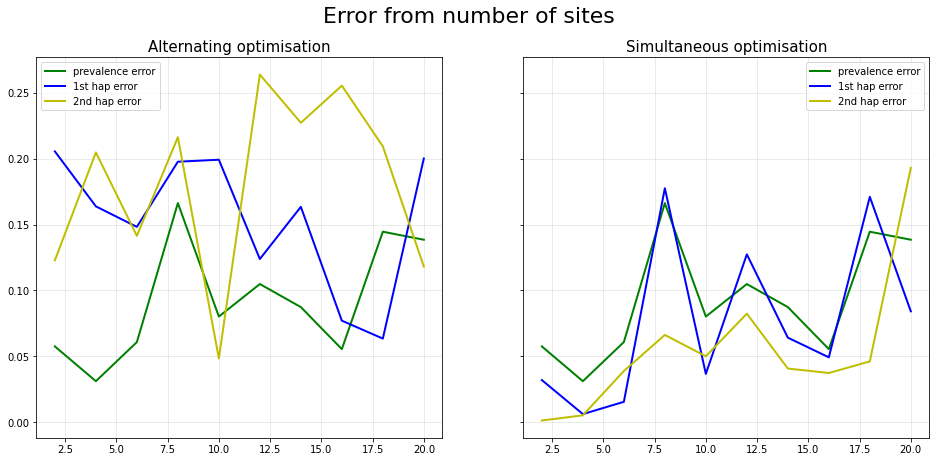

In [25]:
fig_sn_2, ax_sn_2 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_sn_2.suptitle('Error from number of sites', fontsize=22)
ax_sn_2[0].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], prev_er_alt, 'g', linewidth=2, label='prevalence error')
ax_sn_2[0].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], haps_er_alt[:, 0], 'b', linewidth=2, label='1st hap error')
ax_sn_2[0].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], haps_er_alt[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_sn_2[0].set_title('Alternating optimisation', fontsize=15)
ax_sn_2[0].grid(axis='both', alpha=.3)
ax_sn_2[0].legend()

ax_sn_2[1].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], prev_er_sim, 'g', linewidth=2, label='prevalence error')
ax_sn_2[1].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], haps_er_sim[:, 0], 'b', linewidth=2, label='1st hap error')
ax_sn_2[1].plot([2, 4, 6, 8, 10, 12, 14, 16, 18, 20], haps_er_sim[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_sn_2[1].set_title('Simultaneous optimisation', fontsize=15)
ax_sn_2[1].grid(axis='both', alpha=.3)
ax_sn_2[1].legend()

plt.show()

## Various single strain probability

In [ ]:
e_time_s_rate = []
p_acc_s_rate = []
h_acс_s_rate = []
for s_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]:
  haps = np.ones((2, 4))
  haps[0][int(4/2):]=0.
  haps[1][:int(4/2)]=0.
  hap_len = len(haps[0])
  exec_time_alt = 0.
  prev_ac_alt = 0.
  haps_ac_alt = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(samp_num, s_rate)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = alter_opt(haps, exmp_prevs, patients_data)

    exec_time_alt+= exec_time
    prev_ac_alt += prev_ac
    haps_ac_alt += haps_ac
    
  
  p_acc_s_rate.append(prev_ac_alt/iter_num)
  h_acс_s_rate.append(haps_ac_alt/iter_num)
  e_time_s_rate.append(exec_time_alt/iter_num)
  
print("Runtime:", e_time_s_rate)
print("Eval prev error:", p_acc_s_rate)
print("Eval haps error:", h_acс_s_rate)

In [ ]:
time_sr_alt = [9.795536370277405, 9.933450722694397, 10.72708860874176, 11.036569986343384, 12.41419029712677, 12.944283709526061, 13.500107641220092, 14.749024415016175, 15.297402153015137, 15.613477692604064]
prev_er_sr_alt = [0.1534453416205051, 0.15695018223573182, 0.14253473086200302, 0.13225283006441685, 0.148194171578309, 0.12523327948213095, 0.13987717011380665, 0.08226434367323146, 0.08238307688728802, 0.027648683219593906]
haps_er_sr_alt = np.array([[0.15621886, 0.12971499], [0.16023302, 0.15138001], [0.15071972, 0.13751491], [0.13355542, 0.14366303], [0.14239761, 0.14966568], [0.10079825, 0.15050216], [0.17563339, 0.1293327 ], [0.09325591, 0.07560185], [0.08076135, 0.09826325], [0.12566862, 0.09401375]])


In [ ]:
e_time_sim_s_rate = []
p_acc_sim_s_rate = []
h_acс_sim_s_rate = []
for s_rate in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]:
  haps = np.ones((2, 4))
  haps[0][int(4/2):]=0.
  haps[1][:int(4/2)]=0.
  hap_len = len(haps[0])
  exec_time_sim = 0.
  prev_ac_sim = 0.
  haps_ac_sim = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(samp_num, s_rate)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = sim_opt(haps, exmp_prevs, patients_data, hap_len)
    exec_time_sim += exec_time
    prev_ac_sim += prev_ac
    haps_ac_sim += haps_ac
  
  p_acc_sim_s_rate.append(prev_ac_sim/iter_num)
  h_acс_sim_s_rate.append(haps_ac_sim/iter_num)
  e_time_sim_s_rate.append(exec_time_sim/iter_num)
  
print("Runtime:", e_time_sim_s_rate)
print("Eval prev error:", p_acc_sim_s_rate)
print("Eval haps error:", h_acс_sim_s_rate)

In [ ]:
time_sr_sim = [16.61736814022064, 15.146343574523925, 14.075658140182496, 13.216987028121949, 12.642773327827454, 12.630668869018555, 12.50103093624115, 12.245297012329102, 11.810057315826416, 11.15750949382782]
prev_er_sr_sim = [0.11750633156741197, 0.0843111103509645, 0.057242042441695694, 0.037081753279664384, 0.028594647767983917, 0.039926400678025206, 0.024321935198293274, 0.012258904469245541, 0.007417717121967594, 5.410830841708296e-05]
haps_er_sr_sim = np.array([[0.0883212 , 0.11449783], [0.04795801, 0.05892471], [0.02346581, 0.04300523], [0.01103455, 0.02168404], [0.01169802, 0.01214534], [0.02485291, 0.02821814], [0.0216335 , 0.01130813], [0.00235789, 0.00198047], [0.0007639 , 0.00260765], [4.56321740e-05, 4.66649376e-05]])

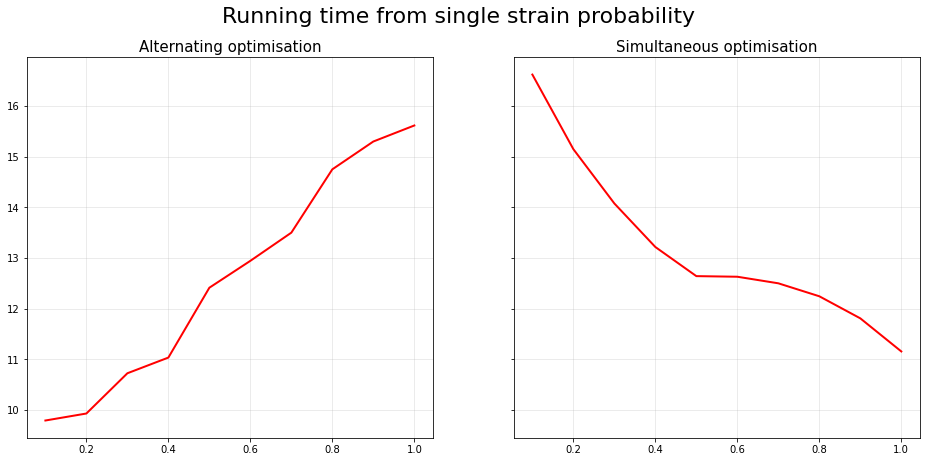

In [ ]:
fig_sr_1, ax_sr_1 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_sr_1.suptitle('Running time from single strain probability', fontsize=22)
ax_sr_1[0].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], time_sr_alt, 'r', linewidth=2)
ax_sr_1[0].set_title('Alternating optimisation', fontsize=15)
ax_sr_1[0].grid(axis='both', alpha=.3)

ax_sr_1[1].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], time_sr_sim, 'r', linewidth=2)
ax_sr_1[1].set_title('Simultaneous optimisation', fontsize=15)
ax_sr_1[1].grid(axis='both', alpha=.3)

plt.show()

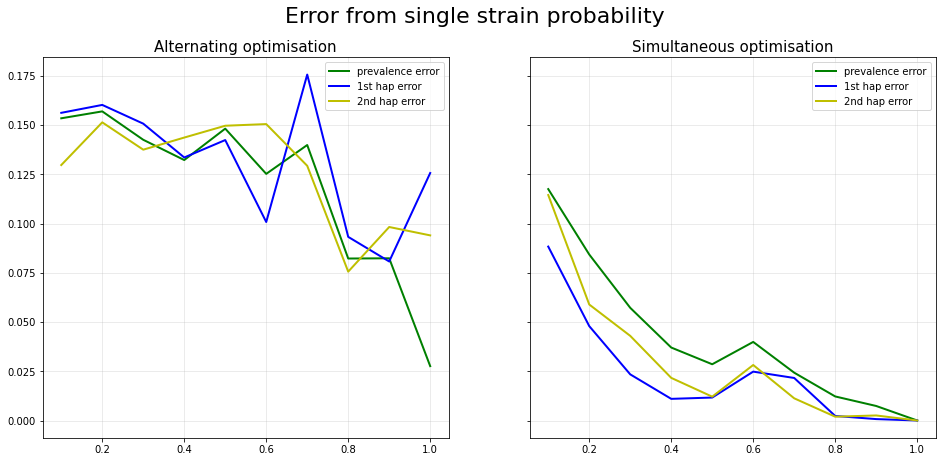

In [ ]:
fig_sr_2, ax_sr_2 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_sr_2.suptitle('Error from single strain probability', fontsize=22)
ax_sr_2[0].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], prev_er_sr_alt, 'g', linewidth=2, label='prevalence error')
ax_sr_2[0].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], haps_er_sr_alt[:, 0], 'b', linewidth=2, label='1st hap error')
ax_sr_2[0].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], haps_er_sr_alt[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_sr_2[0].set_title('Alternating optimisation', fontsize=15)
ax_sr_2[0].grid(axis='both', alpha=.3)
ax_sr_2[0].legend()

ax_sr_2[1].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], prev_er_sr_sim, 'g', linewidth=2, label='prevalence error')
ax_sr_2[1].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], haps_er_sr_sim[:, 0], 'b', linewidth=2, label='1st hap error')
ax_sr_2[1].plot([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.], haps_er_sr_sim[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_sr_2[1].set_title('Simultaneous optimisation', fontsize=15)
ax_sr_2[1].grid(axis='both', alpha=.3)
ax_sr_2[1].legend()

plt.show()

## Various number of hosts

In [ ]:
e_time_hn = []
p_acc_hn = []
h_acс_hn = []
for hn in range(5, 16):
  haps = np.ones((2, 4))
  haps[0][int(4/2):]=0.
  haps[1][:int(4/2)]=0.
  hap_len = len(haps[0])
  exec_time_alt = 0.
  prev_ac_alt = 0.
  haps_ac_alt = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(hn, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = alter_opt(haps, exmp_prevs, patients_data)

    exec_time_alt+= exec_time
    prev_ac_alt += prev_ac
    haps_ac_alt += haps_ac
    
  
  p_acc_hn.append(prev_ac_alt/iter_num)
  h_acс_hn.append(haps_ac_alt/iter_num)
  e_time_hn.append(exec_time_alt/iter_num)
  
print("Runtime:", e_time_hn)
print("Eval prev error:", p_acc_hn)
print("Eval haps error:", h_acс_hn)

In [ ]:
time_hn_alt = [7.1735669612884525, 8.302122755050659, 9.060335750579833, 9.462946290969848, 10.827292838096618, 11.311988911628724, 13.27618067741394, 13.794615631103516, 14.747105164527893, 15.38149010181427, 16.56052186012268]
prev_er_hn_alt = [0.24323621909102275, 0.22638312146593864, 0.21676023352403792, 0.17284280109926073, 0.22501375794027734, 0.1872650092738064, 0.11735852285764008, 0.14211865019884778, 0.11591636904754139, 0.14333679839914423, 0.13524529131132648]
haps_er_hn_alt = np.array([[0.15557396, 0.20672971], [0.17520133, 0.14537747], [0.15433811, 0.21578823], [0.17368296, 0.13113496], [0.17529068, 0.14659901], [0.16696074, 0.19132866], [0.12738597, 0.10976832], [0.14535675, 0.13373071], [0.10738228, 0.15746833], [0.13123002, 0.16088403], [0.15613079, 0.13211017]])

In [ ]:
e_time_sim_hn= []
p_acc_sim_hn = []
h_acс_sim_hn = []
for hn in range(5, 16):
  haps = np.ones((2, 4))
  haps[0][int(4/2):]=0.
  haps[1][:int(4/2)]=0.
  hap_len = len(haps[0])
  exec_time_sim = 0.
  prev_ac_sim = 0.
  haps_ac_sim = np.zeros(2)
  for j in range(iter_num):
    exmp_prevs = Prevalence(hn, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = sim_opt(haps, exmp_prevs, patients_data, hap_len)
    exec_time_sim += exec_time
    prev_ac_sim += prev_ac
    haps_ac_sim += haps_ac
  
  p_acc_sim_hn.append(prev_ac_sim/iter_num)
  h_acс_sim_hn.append(haps_ac_sim/iter_num)
  e_time_sim_hn.append(exec_time_sim/iter_num)
  
print("Runtime:", e_time_sim_hn)
print("Eval prev error:", p_acc_sim_hn)
print("Eval haps error:", h_acс_sim_hn)

In [ ]:
time_hn_sim = [8.75210165977478, 9.781841320991516, 10.634602589607239, 11.830212659835816, 13.16928427219391, 14.08761884689331, 15.636161217689514, 16.378441739082337, 17.820912594795228, 19.296238827705384, 20.40204273700714]
prev_er_hn_sim = [0.15605640875673368, 0.12038159327731326, 0.11703712438319917, 0.0995679273695112, 0.06406121130211384, 0.05962623771392246, 0.04238490535403285, 0.04750984388278311, 0.03824592400325825, 0.0540456334020788, 0.05222520933137188]
haps_er_hn_sim = np.array([[0.11523944, 0.12663703], [0.08200843, 0.08134134], [0.06175823, 0.03517826], [0.05915739, 0.07332409], [0.04821969, 0.03445251], [0.04099079, 0.01840956], [0.02127611, 0.02904412], [0.01667895, 0.03616362], [0.01290593, 0.01928853], [0.03073351, 0.01603659], [0.02957321, 0.01841762]])

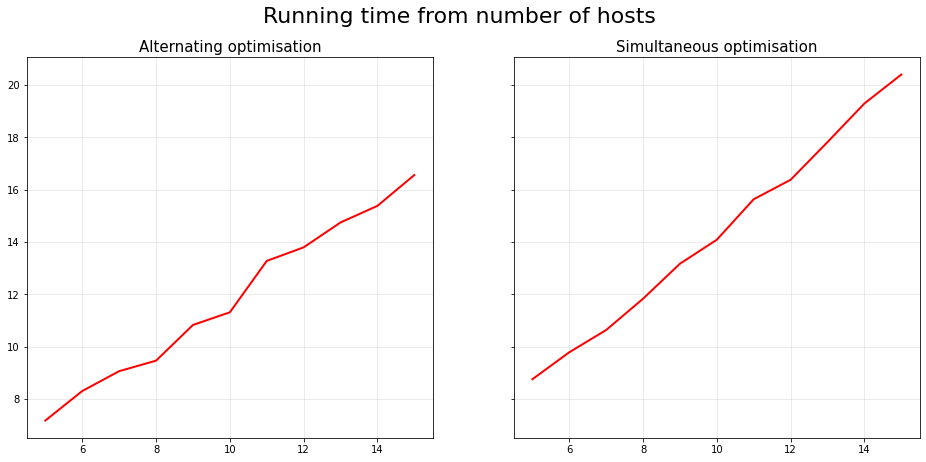

In [ ]:
fig_hn_1, ax_hn_1 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_hn_1.suptitle('Running time from number of hosts', fontsize=22)
ax_hn_1[0].plot(range(5, 16), time_hn_alt, 'r', linewidth=2)
ax_hn_1[0].set_title('Alternating optimisation', fontsize=15)
ax_hn_1[0].grid(axis='both', alpha=.3)

ax_hn_1[1].plot(range(5, 16), time_hn_sim, 'r', linewidth=2)
ax_hn_1[1].set_title('Simultaneous optimisation', fontsize=15)
ax_hn_1[1].grid(axis='both', alpha=.3)

plt.show()

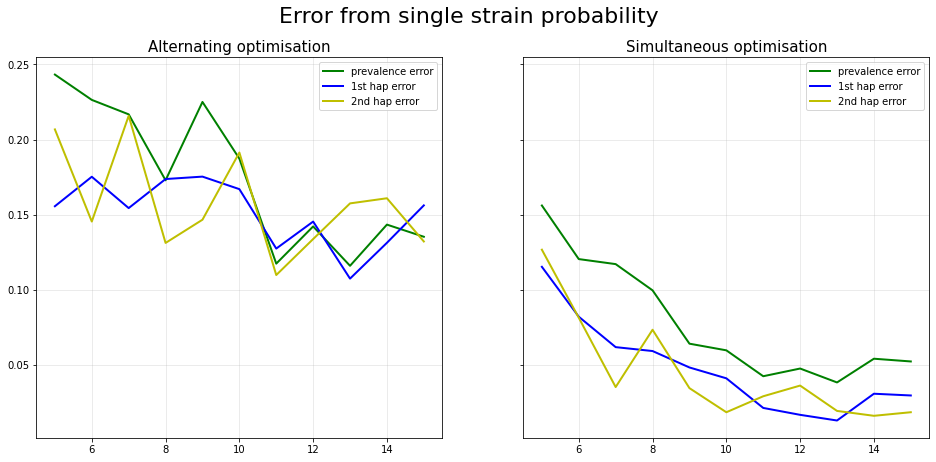

In [ ]:
fig_hn_2, ax_hn_2 = plt.subplots(1, 2, sharey=True, figsize=[16, 7])

fig_hn_2.suptitle('Error from single strain probability', fontsize=22)
ax_hn_2[0].plot(range(5, 16), prev_er_hn_alt, 'g', linewidth=2, label='prevalence error')
ax_hn_2[0].plot(range(5, 16), haps_er_hn_alt[:, 0], 'b', linewidth=2, label='1st hap error')
ax_hn_2[0].plot(range(5, 16), haps_er_hn_alt[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_hn_2[0].set_title('Alternating optimisation', fontsize=15)
ax_hn_2[0].grid(axis='both', alpha=.3)
ax_hn_2[0].legend()

ax_hn_2[1].plot(range(5, 16), prev_er_hn_sim, 'g', linewidth=2, label='prevalence error')
ax_hn_2[1].plot(range(5, 16), haps_er_hn_sim[:, 0], 'b', linewidth=2, label='1st hap error')
ax_hn_2[1].plot(range(5, 16), haps_er_hn_sim[:, 1], 'y', linewidth=2, label='2nd hap error')
ax_hn_2[1].set_title('Simultaneous optimisation', fontsize=15)
ax_hn_2[1].grid(axis='both', alpha=.3)
ax_hn_2[1].legend()

plt.show()

## Various strain structure

In [ ]:
diff_haps = np.array([ [[1., 1., 0.2, 0.2], [0.3, 0.3, 1., 1.]] ])

In [ ]:
e_time_h = []
p_acc_h = []
h_acс_h = []
for h in diff_haps:
  haps = h
  hap_len = len(haps[0])
  exec_time_alt = 0.
  prev_ac_alt = 0.
  haps_ac_alt = np.zeros(2)
  for j in range(10):
    exmp_prevs = Prevalence(10, 0.3)
    patients_data = SimulateReads(haps, exmp_prevs, er_rate=0.)
    exec_time, prev_ac, haps_ac = alter_opt(haps, exmp_prevs, patients_data)

    exec_time_alt+= exec_time
    prev_ac_alt += prev_ac
    haps_ac_alt += haps_ac
    
  
  p_acc_h.append(prev_ac_alt/10)
  h_acс_h.append(haps_ac_alt/10)
  e_time_h.append(exec_time_alt/10)
  
print("Runtime:", e_time_h)
print("Eval prev error:", p_acc_h)
print("Eval haps error:", h_acс_h)